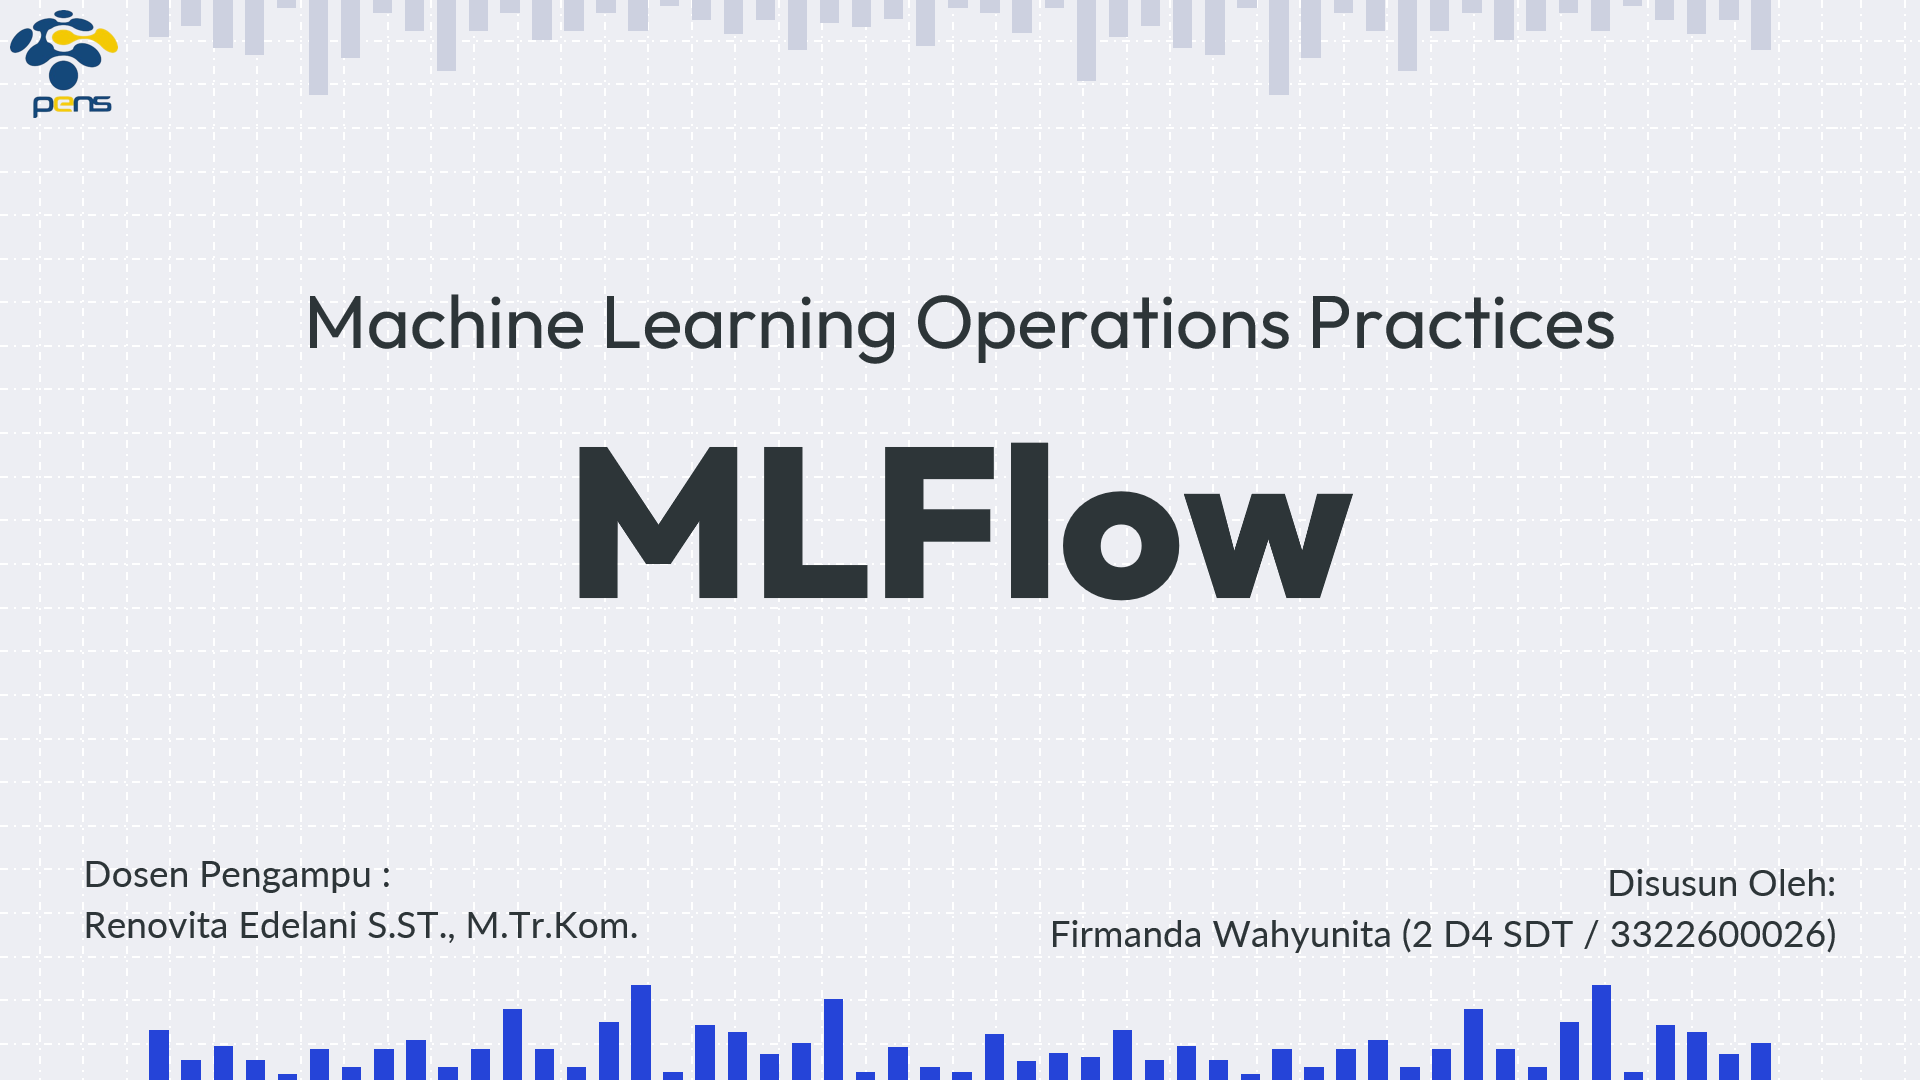

# MLFlow

MLflow adalah platform terbuka yang menyederhanakan seluruh proses machine learning. Dengan lingkungan konstan dan fleksibel, MLflow mendukung pengembangan, pengujian, reproduksi, paket, dan deployment model. Fitur tracking eksperimen memungkinkan penyimpanan parameter, metrik, dan artifact untuk meningkatkan reproduksibilitas model. Integrasi dengan lokasi pengaturan versi, dokumentasi, dan bagian model juga tersedia. Pipelines MLflow memfasilitasi pembuatan workflow kompleks dari eksperimen hingga deployment, mempercepat produktivitas tim dan integrasi model ke lingkungan produksi. MLflow digunakan oleh berbagai profesi seperti data scientists, MLOps professionals, manajer data science, dan pengguna engineering untuk berbagai kebutuhan dalam proyek machine learning, dari pengujian model hingga pengelolaan lifecycle model.

**Sumber: https://mlflow.org/docs/latest/introduction/index.html**

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow
import mlflow.sklearn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix
from mlflow import log_metric, log_param, log_artifacts
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('mlops/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Loading Dataset

In [2]:
try:
        df = pd.read_csv("train.csv")
        print("Dataset loaded successfully")
except Exception as e:
        print(f"Failed to load data. Error: {e}")

Dataset loaded successfully


# MLflow Setup

In [3]:
if __name__ == '__main__':
    print('Starting the experiment')
try:
    experiment_name = "experiment_titanic"
    #mlflow.set_tracking_uri('http://127.0.0.1:5050/')
    if not mlflow.get_experiment_by_name(experiment_name):
        mlflow.create_experiment(name=experiment_name)
        mlflow.set_experiment(experiment_name)
    else:
        mlflow.set_experiment(experiment_name)
except Exception as e:
        print(f"Failed to start experiment. Error: {e}")

Starting the experiment


# Enable & configure autologging for scikit-learn estimators

In [4]:
mlflow.sklearn.autolog(log_model_signatures = True, log_models = True)

2024/04/16 23:09:57 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
survived = df[df['Survived']==1]
not_survided = df[df['Survived']==0]
total_passenger = len(df.Survived)
print('Passenger survival stats: {} i.e., {:.2f}%'.format(len(survived), (len(survived)/total_passenger)*100))
print('Passenger Death stats: {} i.e, {:.2f}%'.format(len(not_survided), (len(not_survided)/total_passenger)*100))

Passenger survival stats: 342 i.e., 38.38%
Passenger Death stats: 549 i.e, 61.62%


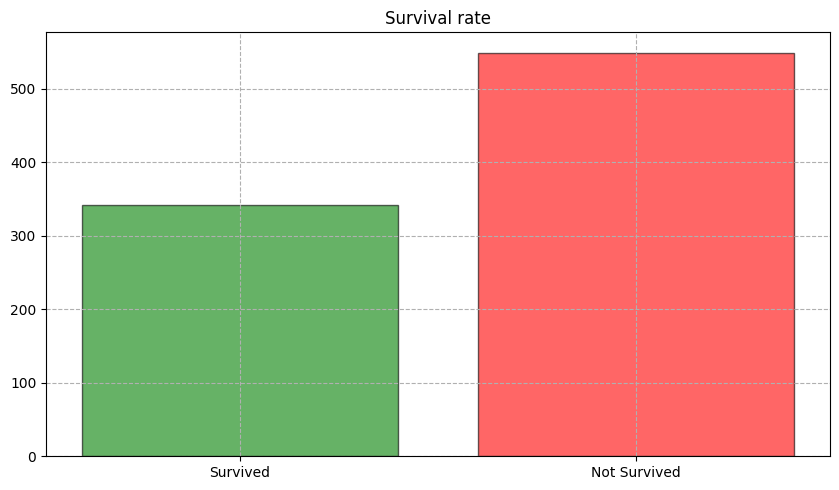

In [7]:
#Plot survived
fig = plt.figure(figsize=(8.5,5))
ax = fig.add_subplot(1,1,1)
ax.set_title('Survival rate')
rects1= ax.bar('Survived', len(survived), color='green', alpha=0.6, edgecolor='k', label='Survived')
rects2= ax.bar('Not Survived', len(not_survided), color='red', alpha=0.6, edgecolor='k', label='Not Survived')
ax.grid(visible=True, which='major', linestyle='--')
plt.tight_layout()

<Axes: >

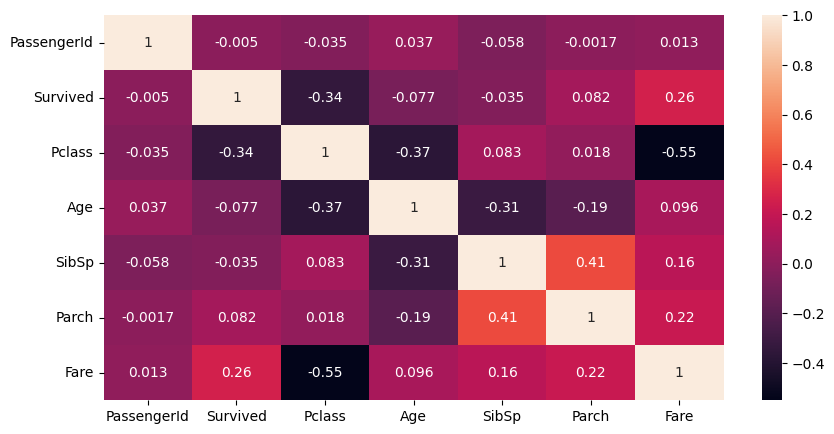

In [8]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_df = df[numeric_cols]
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(numeric_df.corr(), annot=True)

# Feature Engineering

In [9]:
df_feature = df.copy()
df_feature.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
#Data Imputation
df_feature['Age'].fillna(df_feature['Age'].mean(), inplace=True)
df_feature['Embarked'].fillna(method='ffill', inplace=True)
df_feature = df_feature.drop(['Cabin'], axis=1)

In [11]:
df_feature.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [12]:
# Dropping non-numerical data
X = df_feature.drop(['Survived','Name','Ticket'], axis=1)
#Target variable
y = df_feature['Survived']

In [13]:
#Dummy encoding
X = pd.get_dummies(X)

In [14]:
#Reduce Dimensionality
X = X.drop(['Sex_male', 'Embarked_S'], axis= 1)

# Splitting the Dataset into the raining set & test set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=0)

# Log training data shape in MLflow

In [16]:
log_param("Train shape",X_train.shape)

(757, 9)

# Log target variabel value counts in MLflow

In [17]:
log_param("Value counts", df_feature['Survived'].value_counts())

Survived
0    549
1    342
Name: count, dtype: int64

# Scaling Data

In [18]:
sc_x = StandardScaler()
X_train = pd.DataFrame(sc_x.fit_transform(X_train), columns=X.columns.values)
X_test = pd.DataFrame(sc_x.transform(X_test), columns=X.columns.values)

# Model Buliding

In [19]:
error_rate= []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

2024/04/16 23:10:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 3c0ffec7d26847e796bf62297c709926. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'n_neighbors\' was already logged with value=\'1\' for run ID=\'3c0ffec7d26847e796bf62297c709926\'. Attempted logging new value \'2\'.")]')]
2024/04/16 23:10:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 3c0ffec7d26847e796bf62297c709926. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'n_neighbors\' was already logged with value=\'1\' for ru

Text(0, 0.5, 'Error Rate')

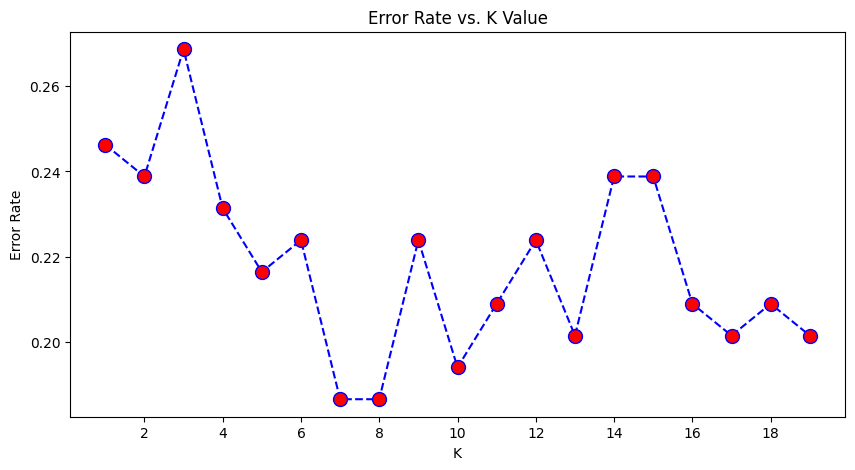

In [20]:
plt.figure(figsize=(10,5))
plt.xticks(list(range(0,21,2)))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [21]:
print(f"Mean error rate is {np.mean(error_rate) * 100:.0f}%")
print("Minimum error rate is {:.0f}% when the value of n_neighbors is {}".format(min(error_rate) * 100,
                                                                                 error_rate.index(min(error_rate)) + 1))

Mean error rate is 22%
Minimum error rate is 19% when the value of n_neighbors is 7


# Choosing Hyperparameters

In [22]:
n_neighbors = 7
p=2
metric = 'minkowski'
weights : 'uniform' #distance

# Log Hyperparameters for the model in MLflow

In [23]:
log_metric("n_neighbors", n_neighbors)
log_metric("p", p)

# Predicting the test target variable

In [24]:
kn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, p= p) #19, 2
kn_classifier.fit(X_train, y_train)

# Predicting the Test set target
y_pred = kn_classifier.predict(X_test)

2024/04/16 23:11:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 3c0ffec7d26847e796bf62297c709926. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'n_neighbors\' was already logged with value=\'1\' for run ID=\'3c0ffec7d26847e796bf62297c709926\'. Attempted logging new value \'7\'.")]')]


# Log Metrics for the model in MLflow

In [25]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

log_metric("Accuracy", acc)
log_metric("Precision", prec)
log_metric("Recall", rec)
log_metric("F1 Score", f1)

print(f"Accuracy: {acc:.2f} | Precision: {prec:.2f} | Recall: {rec:.2f} | F1 Score: {f1:.2f}")

Accuracy: 0.81 | Precision: 0.78 | Recall: 0.71 | F1 Score: 0.74


# Log the Model & the dataset as an artifact

In [26]:
mlflow.sklearn.log_model(knn, "Models")

In [27]:
# uncomment to run mlflow ui
!mlflow ui

^C


In [28]:
mlflow.end_run()